In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#torch.manual_seed(111)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


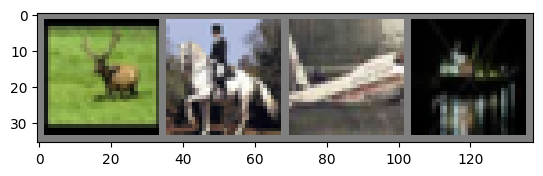

deer  horse plane ship 


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      epoch_loss = []
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      epoch_loss.append(loss.item())
      if (i + 1) % 2000 == 0:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
          running_loss = 0.0
  print(f"Mean epoch loss: {np.mean(epoch_loss)}")

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.883
[1,  6000] loss: 1.654
[1,  8000] loss: 1.561
[1, 10000] loss: 1.506
[1, 12000] loss: 1.430
Mean epoch loss: 2.060713052749634
[2,  2000] loss: 1.391
[2,  4000] loss: 1.358
[2,  6000] loss: 1.327
[2,  8000] loss: 1.305
[2, 10000] loss: 1.274
[2, 12000] loss: 1.276
Mean epoch loss: 0.6642045378684998
Finished Training


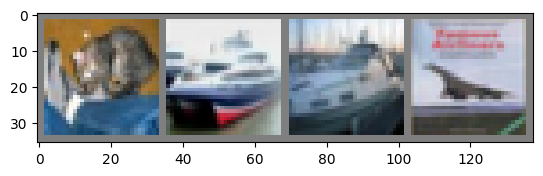

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  dog   dog   deer  horse


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, label = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.0 %
Accuracy for class: car   is 59.8 %
Accuracy for class: bird  is 24.4 %
Accuracy for class: cat   is 40.1 %
Accuracy for class: deer  is 47.1 %
Accuracy for class: dog   is 51.1 %
Accuracy for class: frog  is 63.6 %
Accuracy for class: horse is 70.8 %
Accuracy for class: ship  is 71.7 %
Accuracy for class: truck is 72.0 %


## Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.

In [ ]:
def get_mean_std(trainLoader):
    imgs = None
    for batch in trainLoader:
        image_batch = batch[0]
        if imgs is None:
            imgs = image_batch.cpu()
        else:
            imgs = torch.cat([imgs, image_batch.cpu()], dim=0)
    imgs = imgs.numpy()

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()
    print(mean_r,mean_g,mean_b)

    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()
    print(std_r,std_g,std_b)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
get_mean_std(trainloader)

0.4914001 0.48215786 0.44653177
0.24703239 0.24348521 0.2615877


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
get_mean_std(trainloader)

-4.2363047e-07 4.2770134e-06 -1.2038541e-06
0.9999998 1.0000013 0.99999994


### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

In [6]:
def train(epochs, trainloader, net, optimizer, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 2000 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(running_loss)
            else:
                scheduler.step()
    print('Finished Training')

In [7]:
def test(testloader, net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, label = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [8]:
def test_class(testloader, net):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [11]:
# optimizer.step() after validation if it's done

from torch.optim.lr_scheduler import MultiStepLR
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.00002)
net = Net().to(device)

train(5, trainloader, net, optimizer, criterion)
test(testloader, net)
test_class(testloader, net)
#TODO try different scheduler, more epochs -> check milestones, print loss of train
# 2 o 3 schedulers diversi
# prova quello che cala da solo in presenza di un Plateau


[1,   500] loss: 2.306
[1,  1000] loss: 2.303
[1,  1500] loss: 2.305
[1,  2000] loss: 2.304
[1,  2500] loss: 2.307
[1,  3000] loss: 2.304
[1,  3500] loss: 2.302
[1,  4000] loss: 2.306


KeyboardInterrupt: 

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[1, 7], gamma=0.1) #TODO quando ci sarà seed sistema milestone

net = train(10, trainloader, optimizer, scheduler, criterion)
test(testloader, net)
test_class(testloader, net)

Epoch mean loss: 2.307
Epoch mean loss: 2.313
Epoch mean loss: 2.291
Epoch mean loss: 2.308
Epoch mean loss: 2.300
Epoch mean loss: 2.295
Epoch mean loss: 2.289
Epoch mean loss: 2.310
Epoch mean loss: 2.333


KeyboardInterrupt: 

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

net = train(10, trainloader, optimizer, scheduler, criterion)
test(testloader, net)
test_class(testloader, net)

Epoch mean loss: 2.287
Epoch mean loss: 2.288
Epoch mean loss: 2.306
Epoch mean loss: 2.275
Epoch mean loss: 2.292
Epoch mean loss: 2.327
Epoch mean loss: 2.286
Epoch mean loss: 2.293
Epoch mean loss: 2.336
Epoch mean loss: 2.331
Finished Training
Accuracy of the network on the 10000 test images: 9 %
Accuracy for class: plane is 0.1 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 99.6 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


In [ ]:
# No convergence, let's change optimizer
# optimizer.step() after validation if it's done

from torch.optim.lr_scheduler import MultiStepLR
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[26], gamma=0.1) # milestone higher than number of epochs -> scheduler not used

train(10, trainloader, optimizer, scheduler, criterion)
test(testloader, net)
test_class(testloader, net)

Epoch mean loss: 2.345
Epoch mean loss: 2.313
Epoch mean loss: 2.297
Epoch mean loss: 2.315
Epoch mean loss: 2.322
Epoch mean loss: 2.315
Epoch mean loss: 2.300
Epoch mean loss: 2.316
Epoch mean loss: 2.301
Epoch mean loss: 2.333
Finished Training
Accuracy of the network on the 10000 test images: 8 %
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 2.4 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.6 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 85.9 %


In [ ]:
# Change model


## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.RandomPerspective(),
                                transforms.RandomRotation(10),
                                transforms.GaussianBlur(3),
                                transforms.RandomGrayscale()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

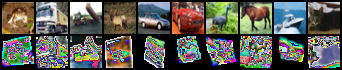

In [ ]:
# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

Now use it to train the your model

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)
net = train(10, trainloader, optimizer, scheduler, criterion)
test(testloader, net)
test_class(testloader, net)
#TODO provare 2 o 3 trasformazioni diverse, di solito si usa randomcrop e flip per classificazione, al max colorgitter
# far vedere che con data aug particolari complico troppo training -> underfitting

Epoch mean loss: 2.299
Epoch mean loss: 2.317
Epoch mean loss: 2.308
Epoch mean loss: 2.282
Epoch mean loss: 2.306
Epoch mean loss: 2.284
Epoch mean loss: 2.319
Epoch mean loss: 2.329
Epoch mean loss: 2.284
Epoch mean loss: 2.289
Finished Training
Accuracy of the network on the 10000 test images: 45 %
Accuracy for class: plane is 61.5 %
Accuracy for class: car   is 67.2 %
Accuracy for class: bird  is 13.2 %
Accuracy for class: cat   is 20.9 %
Accuracy for class: deer  is 11.8 %
Accuracy for class: dog   is 50.5 %
Accuracy for class: frog  is 37.3 %
Accuracy for class: horse is 61.5 %
Accuracy for class: ship  is 55.0 %
Accuracy for class: truck is 80.3 %


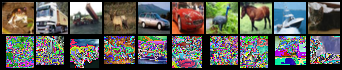

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)
net = train(10, trainloader, optimizer, scheduler, criterion)
test(testloader, net)
test_class(testloader, net)

Epoch mean loss: 2.280
Epoch mean loss: 2.311
Epoch mean loss: 2.334
Epoch mean loss: 2.308
Epoch mean loss: 2.283
Epoch mean loss: 2.341
Epoch mean loss: 2.265
Epoch mean loss: 2.288
Epoch mean loss: 2.303
Epoch mean loss: 2.300
Finished Training
Accuracy of the network on the 10000 test images: 45 %
Accuracy for class: plane is 61.5 %
Accuracy for class: car   is 67.2 %
Accuracy for class: bird  is 13.2 %
Accuracy for class: cat   is 20.9 %
Accuracy for class: deer  is 11.8 %
Accuracy for class: dog   is 50.5 %
Accuracy for class: frog  is 37.3 %
Accuracy for class: horse is 61.5 %
Accuracy for class: ship  is 55.0 %
Accuracy for class: truck is 80.3 %


In [ ]:
#TODO prova altra trasformazione?

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [ ]:
#TODO run exercise with ssh
# Exercise 3A

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Network with all linear layers
class FC_Net(nn.Module):
    def __init__(self, input_size = 1024, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = self.last_layer(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(epochs, trainloader, optimizer, net, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            epoch_loss = []
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss.append(loss.item())
            #if (i + 1) % 500 == 0:    # print every 5000 mini-batches
             #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
              #  running_loss = 0.0
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(np.mean(epoch_loss))
        else:
            scheduler.step()
        print(f"Epoch mean loss: {np.mean(epoch_loss):.3f}")
    print('Finished Training')

In [ ]:
model1 = FC_Net(layers = [32, 64 ,128])
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model1, criterion)
test(testloader, model1)
test_class(testloader, model1)

model2 = FC_Net(layers = [40768, 40768]) # few large layers -> overfitting, too much parameters
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

model3 = FC_Net(layers = [32, 32, 32, 32, 32, 32, 32, 32, 32]) # vanishing gradient
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model3, criterion)
test(testloader, model3)
test_class(testloader, model3)

In [ ]:
# Changing CNN hyperparameters:

class Net(nn.Module):
    def __init__(self, kernel_size=5, stride=1, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size, stride, padding)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #TODO change dimensions when varying parameters
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Changing kernel dimension of the conv layers
model1 = Net(kernel_size=3)
model2 = Net(kernel_size=1)
model3 = Net(kernel_size=7)

In [ ]:
# Changing padding of the conv layers, based on the previous models to see improvements with increased kernel size
model1 = Net(kernel_size=5, padding=2)
model2 = Net(kernel_size=7, padding=3)

In [ ]:
# Changing stride of the conv layers
model1 = Net(stride=2)
model2 = Net(stride=3)
model3 = Net(stride=4) #TODO verificare se fattibile

In [9]:
# Exercise 3B

import torchvision.models as models
alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()

def train(epochs, trainloader, net, optimizer, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 500 == 0:    # print every 5000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(running_loss)
            else:
                scheduler.step()
    print('Finished Training')

In [ ]:
alexnet.fc = nn.Linear(512, 10) #TODO ask if ok to resize
alexnet.to(device)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((469, 387))]) # Resized like ImageNet, otherwise there was an error with the predefined model
                                                                # because there was a global pooling that made the images 0x0
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, alexnet, optimizer, criterion)
test(testloader, alexnet)
test_class(testloader, alexnet)

[1,   500] loss: 1.726


KeyboardInterrupt: 

In [11]:
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, resnet18, optimizer, criterion)
test(testloader, resnet18)
test_class(testloader, resnet18)

[1,   500] loss: 1.701
[2,   500] loss: 1.262
[3,   500] loss: 1.048
[4,   500] loss: 0.880
[5,   500] loss: 0.736
[6,   500] loss: 0.603
[7,   500] loss: 0.482
[8,   500] loss: 0.379
[9,   500] loss: 0.293
[10,   500] loss: 0.241
[11,   500] loss: 0.208
[12,   500] loss: 0.172
[13,   500] loss: 0.129
[14,   500] loss: 0.117
[15,   500] loss: 0.115
[16,   500] loss: 0.089
[17,   500] loss: 0.083
[18,   500] loss: 0.065
[19,   500] loss: 0.059
[20,   500] loss: 0.051
[21,   500] loss: 0.062
[22,   500] loss: 0.056
[23,   500] loss: 0.040
[24,   500] loss: 0.033
[25,   500] loss: 0.035
[26,   500] loss: 0.033
[27,   500] loss: 0.031
[28,   500] loss: 0.029
[29,   500] loss: 0.025
[30,   500] loss: 0.031
Finished Training
Accuracy of the network on the 10000 test images: 66 %
Accuracy for class: plane is 71.3 %
Accuracy for class: car   is 78.0 %
Accuracy for class: bird  is 55.4 %
Accuracy for class: cat   is 46.7 %
Accuracy for class: deer  is 61.1 %
Accuracy for class: dog   is 50.9 %


In [14]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(30, trainloader, resnet18, optimizer, criterion, scheduler)
test(testloader, resnet18)
test_class(testloader, resnet18)

[1,   500] loss: 1.677
[2,   500] loss: 1.110
[3,   500] loss: 0.880
[4,   500] loss: 0.724
[5,   500] loss: 0.600
[6,   500] loss: 0.496
[7,   500] loss: 0.406
[8,   500] loss: 0.325
[9,   500] loss: 0.260
[10,   500] loss: 0.212
[11,   500] loss: 0.176
[12,   500] loss: 0.141
[13,   500] loss: 0.128
[14,   500] loss: 0.105
[15,   500] loss: 0.087
[16,   500] loss: 0.072
[17,   500] loss: 0.073
[18,   500] loss: 0.058
[19,   500] loss: 0.064
[20,   500] loss: 0.043
[21,   500] loss: 0.046
[22,   500] loss: 0.044
[23,   500] loss: 0.020
[24,   500] loss: 0.006
[25,   500] loss: 0.004
[26,   500] loss: 0.003
[27,   500] loss: 0.003
[28,   500] loss: 0.002
[29,   500] loss: 0.002
[30,   500] loss: 0.002
Finished Training
Accuracy of the network on the 10000 test images: 76 %
Accuracy for class: plane is 80.9 %
Accuracy for class: car   is 85.9 %
Accuracy for class: bird  is 67.2 %
Accuracy for class: cat   is 57.0 %
Accuracy for class: deer  is 74.9 %
Accuracy for class: dog   is 66.1 %


In [12]:
vgg16.fc = nn.Linear(512, 10)
vgg16.to(device)

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, vgg16, optimizer, criterion)
test(testloader, vgg16)
test_class(testloader, vgg16)

[1,   500] loss: 2.680
[2,   500] loss: 1.802
[3,   500] loss: 1.462
[4,   500] loss: 1.244
[5,   500] loss: 1.069
[6,   500] loss: 0.938
[7,   500] loss: 0.826
[8,   500] loss: 0.711
[9,   500] loss: 0.615
[10,   500] loss: 0.533
[11,   500] loss: 0.462
[12,   500] loss: 0.386
[13,   500] loss: 0.320
[14,   500] loss: 0.274
[15,   500] loss: 0.233
[16,   500] loss: 0.184
[17,   500] loss: 0.155
[18,   500] loss: 0.135
[19,   500] loss: 0.110
[20,   500] loss: 0.099
[21,   500] loss: 0.081
[22,   500] loss: 0.085
[23,   500] loss: 0.061
[24,   500] loss: 0.056
[25,   500] loss: 0.054
[26,   500] loss: 0.044
[27,   500] loss: 0.041
[28,   500] loss: 0.039
[29,   500] loss: 0.036
[30,   500] loss: 0.025
Finished Training
Accuracy of the network on the 10000 test images: 77 %
Accuracy for class: plane is 82.8 %
Accuracy for class: car   is 89.5 %
Accuracy for class: bird  is 77.2 %
Accuracy for class: cat   is 59.2 %
Accuracy for class: deer  is 74.3 %
Accuracy for class: dog   is 58.5 %
